<a href="https://colab.research.google.com/github/Srinivaskolli45/s4_assignment/blob/main/s9_assignment_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Srinivaskolli45/s4_assignment.git

import sys
sys.path.append('/content/s4_assignment/')

!pip install torch-lr-finder

Cloning into 's4_assignment'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 105 (delta 39), reused 26 (delta 2), pack-reused 0
Receiving objects: 100% (105/105), 1.36 MiB | 14.39 MiB/s, done.
Resolving deltas: 100% (39/39), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchvision
import numpy as np
import copy
import torch.nn as nn
import albumentations as A
from torchvision import datasets
from tqdm.autonotebook import tqdm
from trainModel import fit_model
from testModel import *
from dataLoader import AlbumentationImageDataset
from model9 import Transformer_VIT
#from Assignment_9_model import Transformer
from torch_lr_finder import LRFinder
from torchsummary import summary
import seaborn as sns

<ipython-input-2-23bd9ef1ec7e>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=32


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

CUDA Available: False


100%|██████████| 170498071/170498071 [00:02<00:00, 64448464.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Transformer_VIT().to(device)
print(summary(net, input_size=(3, 32, 32)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 48, 32, 32]          13,824
       BatchNorm2d-8           [-1, 48, 32, 32]              96
              ReLU-9           [-1, 48, 32, 32]               0
        AvgPool2d-10             [-1, 48, 1, 1]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.20E-03


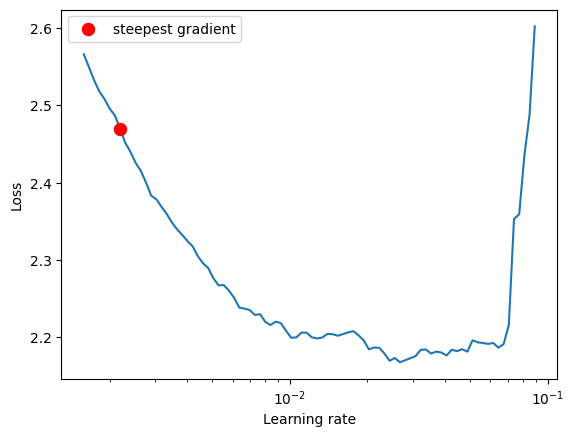

Max LR is 0.026738416158399468


In [5]:
exp_net = copy.deepcopy(net).to(device)
optimizer = torch.optim.Adam(exp_net.parameters(), lr=0.001)
criterion = nn.NLLLoss()
lr_finder = LRFinder(exp_net, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot()
min_loss = min(lr_finder.history['loss'])
ler_rate = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate))

In [6]:

train_net_1 = copy.deepcopy(net).to(device)
optimizer = torch.optim.Adam(train_net_1.parameters(), lr=(ler_rate/10))
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=len(train_loader), 
                                                epochs=24,
                                                pct_start=0.2,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,
train_net_1, history = fit_model(
    train_net_1, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)

EPOCH: 1 (LR: 0.002673841615839947)


Batch_id=262 Loss=2.02074 Accuracy=23.85%:  17%|█▋        | 263/1563 [00:22<01:49, 11.89it/s]


KeyboardInterrupt: ignored

In [ ]:
training_acc, training_loss, testing_acc, testing_loss, lr_trend = history

sns.lineplot(x = list(range(1, 25)), y = training_acc)
sns.lineplot(x = list(range(1, 25)), y = testing_acc)
sns.lineplot(x = list(range(1, 25)), y = training_loss)
sns.lineplot(x = list(range(1, 25)), y = testing_loss)
sns.lineplot(x = list(range(1, len(lr_trend)+1)), y = lr_trend)